In [19]:
import sympy
import numpy as np
import networkx as nx
from math import comb
import scipy.optimize
import matplotlib as mpl
from datetime import datetime
import IPython.display as disp
import matplotlib.pyplot as plt
from itertools import combinations
from joblib import Parallel, delayed
from networkx.utils import py_random_state
import random, time, pickle, random, multiprocessing, matplotlib, copy, itertools

## Bulding the Network

In [4]:
def regular_clique(number_of_nodes, average_degree, clique_size):
    N, K, c = number_of_nodes, average_degree, clique_size
    if K % (c-1) != 0:
        raise Exception('This configuration is not possile')
    else:
        k = int(K/(c-1))
        m = int(N*k/c)
        nodes = [(u, _k) for u in range(N) for _k in range(k)]
        random.shuffle(nodes)
        cliques = [(u, _k) for u in range(m) for _k in range(c)]
        l = list(zip(cliques, nodes))
        my_list = [j[1][0] for j in l]
        node_collections = [my_list[i:i+c] for i in range(0, len(my_list), c)]
        g = nx.Graph()
        for col in node_collections:
            g.add_edges_from(itertools.combinations(col, 2))
        g.remove_edges_from(nx.selfloop_edges(g))
    return g

## Contact Tracing Process

In [5]:
def comp_g(g, compartment_name):
    '''
        returns nodes in compartment compartment_name
    '''
    return [node for node in g.nodes() if g.nodes()[node]['type'] == compartment_name]


def contact_tracing(G, alpha, p):
    '''
        returns number of nodes in different compartments S, I, Q, R
        after runing the SIR+Q process
    '''
    N = len(G)
    infection_seed = random.randint(0, N-1)
    compartments = dict([(infection_seed,{'type':'I'})] + [(node,{'type':'S'}) for node in G.nodes() if node != infection_seed])
    nx.set_node_attributes(G, compartments)
    
    new_seeds = {infection_seed} 
    while new_seeds:
        #check if there is no infection left
        t = [quarantine_infection(seed, G, alpha, p) for seed in new_seeds]
        new_seeds = {item for sublist in t for item in sublist}
    
    S, I, R, Q = comp_g(G, 'S'), comp_g(G, 'I'), comp_g(G, 'R'), comp_g(G, 'Q')

    return [len(S)/N, len(I)/N, len(R)/N, len(Q)/N, len(R)/N + p* len(Q)/N]


def quarantine_infection(infected_node, G, alpha, p):
    '''
        begins from new ifected nodes, yields new infected nodes
        while putting nodes in the right compartment
    '''
    new_infected_nodes = []
    for ne in G[infected_node]:
        if G.nodes()[ne]['type'] == 'S':
            if random.random() <= alpha:
                G.nodes()[ne]['type'] = 'Q'
            else:
                if random.random() <= p:
                    G.nodes()[ne]['type'] = 'I'
                    new_infected_nodes.append(ne)
    G.nodes()[infected_node]['type'] = 'R'
    
    return new_infected_nodes

In [17]:
nk,alpha,p=sympy.Symbol("n_k"),sympy.Symbol(r"\alpha"),sympy.Symbol("p")


def pk(k,quarantines):
    """Probability of infection after k trials given the node is not infected before.
    """
    if quarantines:
        return p*(1-alpha)**k #quarantines
    else:
        return 1-(1-p)*(1-alpha)**(k-1) #the original complex contagion
    

def pkn(k,n,quarantines): # does this work for quarantines? we don't need to forget the quarantine outcome here
    """Same as pk, but when there are n infected neighbors simultaneously trying to infect.
    """
    if quarantines:
        prob=0
        for act in range(n):
            prob=prob+(alpha-1)**(act)*(pk(k+1,quarantines)-1)**(act)*pk(k+1,quarantines)
        return prob
    else:
        prob=1
        for act in range(n):
            prob=prob*(1-pk(k+1+act,quarantines))
        return 1-prob

def process_motif(node,graph,processed,notprocessed,quarantines,singleinftrial=True):
    nsus,ninf,nrec = node
    n=nsus+ninf+nrec
    if ninf>0:
        exp=0
        #Infect others in this clique
        for newinf in range(1,nsus+1):
            #Create the new node
            newnode=(nsus-newinf,newinf,nrec+ninf)
            if newnode not in processed:
                notprocessed.add(newnode)
            
            #Link from this node to the new node 
            if singleinftrial:
                prob=comb(nsus,newinf)*(pk(nrec,quarantines)**newinf)*((1-pk(nrec,quarantines))**(nsus-newinf))
            else:
                prob=comb(nsus,newinf)*(pkn(nrec,ninf,quarantines)**newinf)*((1-pkn(nrec,ninf,quarantines))**(nsus-newinf))
            #prob=comb(nsus,newinf)*(pk(nrec,quarantines)**newinf)*((1-pk(nrec,quarantines))**(nsus-newinf))
            graph.add_edge(node,newnode,weight=prob)
            exp=exp+newinf*prob
        
        #Infect new cliques
        if nsus>0:
            graph.add_edge(node,(n-1,1,0),weight=(nk-1)*exp)
            #graph.add_edge(node,(n-1,1,0),weight=nsus*(nk-1)*pkn(nrec,ninf,quarantines))
            
def pkn_persistent(n):
    """Same as pk, but when there are n infected neighbors simultaneously trying to infect.
    Note that this doesn't depend on k.
    """ 
    prob=0
    for act in range(n):
        prob=prob+(alpha-1)**(act)*(p-1)**(act)*p
    return prob


def process_motif_persistent(node,graph,processed,notprocessed,quarantines,singleinftrial=True):
    nsus,ninf,nrec = node
    n=nsus+ninf+nrec
    if ninf>0:
        exp=0 #expected number of infected nodes
        #Infect others in this clique
        for newinf in range(1,nsus+1): #number of newly infected
            for newrec in range(0,nsus+1-newinf): #number of newly quarantined
                #Create the new node
                newnode=(nsus-newinf-newrec,newinf,nrec+ninf+newrec)
                assert sum(newnode)==sum(node),(node,newnode)
                if newnode not in processed:
                    notprocessed.add(newnode)

                #Link from this node to the new node    
                if singleinftrial:
                    prob=comb(nsus,newinf)*comb(nsus-newinf,newrec)*p**newinf*(1-p)**(nsus-newinf-newrec)*alpha**newrec*(1-alpha)**(nsus-newrec)
                else:
                    prob=comb(nsus,newinf)*comb(nsus-newinf,newrec)*pkn_persistent(ninf)**newinf*(1-pkn_persistent(ninf))**(nsus-newinf-newrec)*alpha**newrec*(1-alpha)**(nsus-newrec)
                graph.add_edge(node,newnode,weight=prob)
                exp=exp+newinf*prob
            
        
        #Infect new cliques
        if nsus>0:
            graph.add_edge(node,(n-1,1,0),weight=(nk-1)*exp)
                  
def motif_graph(motifsize,quarantines=False,persistent=False,singleinftrial=True):
    """Creates a motif graph where nodes are motifs and links are weighted with probabilities of producing
    new motifs in one time step.
    
    Nodes are tuples with three items with following convention:
    (number of susceptible nodes, number of infected nodes, number of recovered nodes)
    
    Parameters
    ----------
    motifsize : The number of nodes in the motif
    quarantines : If 
    """
    if persistent:
        assert quarantines, "Persistent only works with quarantines."
    graph=nx.DiGraph()
    notprocessed=set([(motifsize-1,1,0)])
    processed=set()
    while len(notprocessed)>0:
        node = notprocessed.pop()
        processed.add(node)
        if persistent:
            process_motif_persistent(node,graph,processed,notprocessed,quarantines,singleinftrial)
        else:
            process_motif(node,graph,processed,notprocessed,quarantines,singleinftrial)
    return graph

def canonical_node_order(graph):
    nodes=sorted(graph.nodes(),key=lambda x:list(reversed(x))) #canonical order for nodes
    return nodes

def canonical_node_map(graph):
    nodes=canonical_node_order(graph)
    nodeid=dict(((node,i+1) for i,node in enumerate(nodes)))
    return nodeid

def get_M_matrix(graph,verbose=False):
    nodes=canonical_node_order(graph)
    nodeid=canonical_node_map(graph)
    M=sympy.matrices.zeros(len(nodes),len(nodes))
    if verbose: print(r"$(i,j)$ & $m_{ij}$ \\")
    for node in nodes:
        for neigh in sorted(graph.predecessors(node),key=lambda x:nodeid[x]):
            if verbose: print("$(",nodeid[node],",",nodeid[neigh],")$&",end="")
            if verbose: print("$",sympy.latex(sympy.simplify(graph[neigh][node]['weight'])),r"$\\")
            
            M[nodeid[node]-1,nodeid[neigh]-1]=graph[neigh][node]['weight']
    return M

def numeric_find_alpha(M,nkval,pval):
    Mn=M.subs(nk,nkval).subs(p,pval)
    n=len(M[0,:])
    try:
        alphaval=scipy.optimize.bisect(lambda x:sympy.det(Mn.subs(alpha,x)- sympy.eye(n)),0,1,xtol=0.0001)
        return alphaval
    except ValueError:
        return np.NaN

## Loading from data

/tmp/ipykernel_29925/2483642821.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  current_cmap = copy.copy(matplotlib.cm.get_cmap('viridis'))


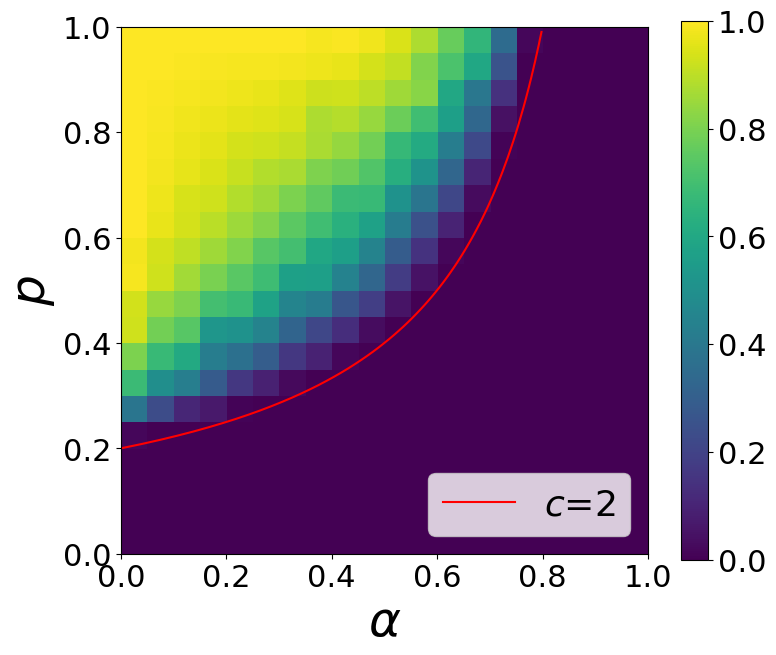

In [22]:
N = 10**5
c = 2

p_range = np.linspace(0.0, 1, 20)
alpha_range = np.linspace(0, 1, 20)
E = np.load(str(c)+'reg_'+str(N)+' er_p_alpha'+'.npy')

fig, axs = plt.subplots(figsize=(8.5,7))

k_nk_vals,ps,quarantines = [(c,6/(c-1))],np.linspace(0.2,0.99,100),True
xmin=None
xmax=None
for kval,nkval in k_nk_vals:
    g = motif_graph(kval,quarantines=True,persistent=True,singleinftrial=False)
    M = get_M_matrix(g)
    alphas = [numeric_find_alpha(M,nkval,pval) for pval in ps]
    axs.plot(alphas,ps,label=r"$c$="+str(kval),c = 'r')

if xmin==None: xmin=ps[0]
if xmax==None: xmax=ps[-1]
    
axs.legend(loc = 4, fontsize = 26)


current_cmap = copy.copy(matplotlib.cm.get_cmap('viridis'))
current_cmap.set_bad('white') 

    
Z = E
Zpos = np.ma.masked_less(Z, 0)
axs.imshow(Z, cmap=current_cmap,  rasterized=True)
pos = axs.imshow(Zpos, cmap=current_cmap, interpolation='none', extent=[0,1, 1, 0],  vmin=0, vmax=1,)
axs.invert_yaxis()
cbar = fig.colorbar(pos , ax=axs)
cbar.ax.tick_params(labelsize=22)
axs.set_ylabel(r'$p$' , fontsize = 35)
axs.set_xlabel(r'$\alpha$' , fontsize = 35)
axs.tick_params(axis='y', labelsize= 22)
axs.tick_params(axis='x', labelsize= 22)
#fig.savefig(str(c)+str(N)+' p_alpha_heatmap.pdf')



/tmp/ipykernel_29925/688150589.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  current_cmap = copy.copy(matplotlib.cm.get_cmap('viridis'))


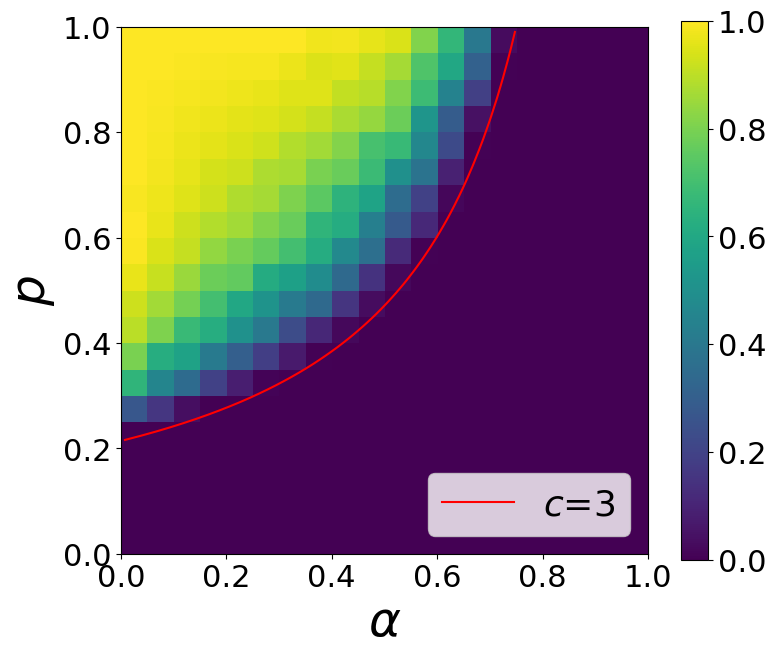

In [20]:
N = 10**5
c = 3

p_range = np.linspace(0.0, 1, 20)
alpha_range = np.linspace(0, 1, 20)
E = np.load(str(c)+'reg_'+str(N)+' er_p_alpha'+'.npy')

fig, axs = plt.subplots(figsize=(8.5,7))

k_nk_vals,ps,quarantines = [(c,6/(c-1))],np.linspace(0.2,0.99,100),True
xmin=None
xmax=None
for kval,nkval in k_nk_vals:
    g = motif_graph(kval,quarantines=True,persistent=True,singleinftrial=False)
    M = get_M_matrix(g)
    alphas = [numeric_find_alpha(M,nkval,pval) for pval in ps]
    axs.plot(alphas,ps,label=r"$c$="+str(kval),c = 'r')

if xmin==None: xmin=ps[0]
if xmax==None: xmax=ps[-1]
    
axs.legend(loc = 4, fontsize = 26)


current_cmap = copy.copy(matplotlib.cm.get_cmap('viridis'))
current_cmap.set_bad('white') 

    
Z = E
Zpos = np.ma.masked_less(Z, 0)
axs.imshow(Z, cmap=current_cmap,  rasterized=True)
pos = axs.imshow(Zpos, cmap=current_cmap, interpolation='none', extent=[0,1, 1, 0],  vmin=0, vmax=1,)
axs.invert_yaxis()
cbar = fig.colorbar(pos , ax=axs)
cbar.ax.tick_params(labelsize=22)
axs.set_ylabel(r'$p$' , fontsize = 35)
axs.set_xlabel(r'$\alpha$' , fontsize = 35)
axs.tick_params(axis='y', labelsize= 22)
axs.tick_params(axis='x', labelsize= 22)
#fig.savefig(str(c)+str(N)+' p_alpha_heatmap.pdf')

/tmp/ipykernel_29925/1100985938.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  current_cmap = copy.copy(matplotlib.cm.get_cmap('viridis'))


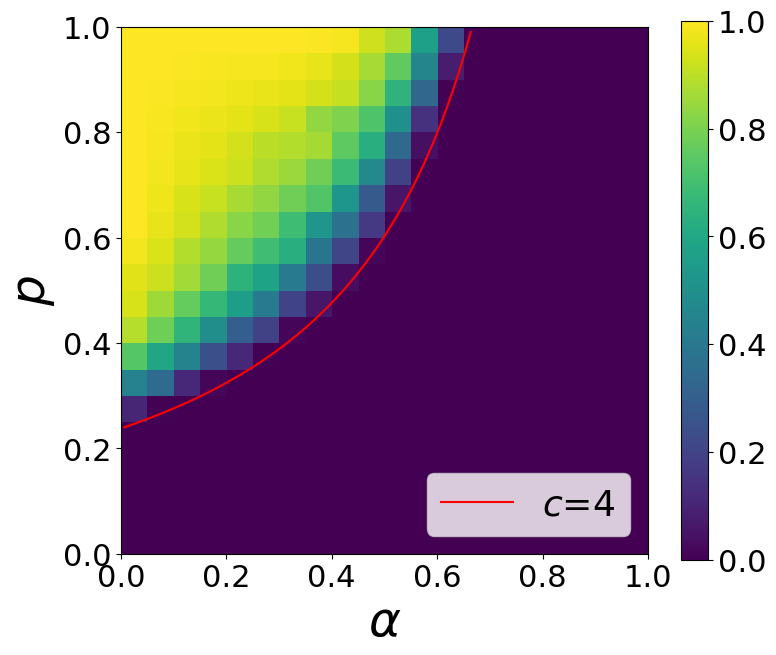

In [21]:
N = 10**5
c = 4

p_range = np.linspace(0.0, 1, 20)
alpha_range = np.linspace(0, 1, 20)
E = np.load(str(c)+'reg_'+str(N)+' er_p_alpha'+'.npy')

fig, axs = plt.subplots(figsize=(8.5,7))

k_nk_vals,ps,quarantines = [(c,6/(c-1))],np.linspace(0.2,0.99,100),True
xmin=None
xmax=None
for kval,nkval in k_nk_vals:
    g = motif_graph(kval,quarantines=True,persistent=True,singleinftrial=False)
    M = get_M_matrix(g)
    alphas = [numeric_find_alpha(M,nkval,pval) for pval in ps]
    axs.plot(alphas,ps,label=r"$c$="+str(kval),c = 'r')

if xmin==None: xmin=ps[0]
if xmax==None: xmax=ps[-1]
    
axs.legend(loc = 4, fontsize = 26)


current_cmap = copy.copy(matplotlib.cm.get_cmap('viridis'))
current_cmap.set_bad('white') 

    
Z = E
Zpos = np.ma.masked_less(Z, 0)
axs.imshow(Z, cmap=current_cmap,  rasterized=True)
pos = axs.imshow(Zpos, cmap=current_cmap, interpolation='none', extent=[0,1, 1, 0],  vmin=0, vmax=1,)
axs.invert_yaxis()
cbar = fig.colorbar(pos , ax=axs)
cbar.ax.tick_params(labelsize=22)
axs.set_ylabel(r'$p$' , fontsize = 35)
axs.set_xlabel(r'$\alpha$' , fontsize = 35)
axs.tick_params(axis='y', labelsize= 22)
axs.tick_params(axis='x', labelsize= 22)
#fig.savefig(str(c)+str(N)+' p_alpha_heatmap.pdf')

